In [265]:
from pathlib import Path

import networkx
import torch
import torchinfo
from torch import nn
from torch_geometric.datasets.citation_full import CitationFull
from torch_geometric.utils import to_networkx
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.common.utils.sparse import ones_tensor
from torchlake.graph.models.gcn import GCN
from torch_geometric.utils import subgraph

# setting

In [241]:
data_path = Path("../../data/pubmed")
artifacts_path = Path("../../artifacts/gcn")

In [242]:
DEVICE = torch.device("cuda:0")

# data

In [243]:
dataset = CitationFull(data_path.as_posix(), 'PubMed')

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:131: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([torch_geometric.data.data.DataEdgeAttr])` to allowlist this global.
  out = fs.torch_load(path)


In [244]:
dataset._data

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717])

In [245]:
networkx.write_gexf(to_networkx(dataset._data, to_undirected=True), artifacts_path / 'pubmed.gexf')

In [246]:
NUM_NODE = len(dataset.x)
NUM_EDGE = dataset.edge_index.size(1)

browse graph in gephi(a JAVA program)

# model

In [307]:
feature_size = dataset.num_node_features
label_size = dataset.num_classes

In [308]:
model = GCN(feature_size, 128, label_size).to(DEVICE)

In [309]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─ModuleList: 1-1                        --
│    └─GCNLayer: 2-1                     --
│    │    └─Linear: 3-1                  64,128
│    └─GCNLayer: 2-2                     --
│    │    └─Linear: 3-2                  387
Total params: 64,515
Trainable params: 64,515
Non-trainable params: 0

# train

In [310]:
LABEL_MASK = torch.rand(NUM_NODE).bernoulli_(0.7).bool()
# NUM_LABELED_NODE = round(0.7 * NUM_NODE)
NUM_LABELED_NODE = LABEL_MASK.sum().item()

In [311]:
print("all", torch.bincount(dataset.y) / NUM_NODE)
print("labeled", torch.bincount(dataset.y[LABEL_MASK]) / NUM_LABELED_NODE)
print("unlabeled", torch.bincount(dataset.y[~LABEL_MASK]) / (NUM_NODE - NUM_LABELED_NODE))

all tensor([0.2081, 0.3925, 0.3994])
labeled tensor([0.2070, 0.3911, 0.4019])
unlabeled tensor([0.2107, 0.3958, 0.3935])


In [312]:
EPOCH = 500

In [313]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [314]:
A = ones_tensor(subgraph(torch.arange(NUM_NODE)[LABEL_MASK], dataset.edge_index)[0], size=(NUM_LABELED_NODE, NUM_LABELED_NODE))

In [315]:
trainer = ClassificationTrainer(epoches=EPOCH, device=DEVICE, feature_last=True)

In [316]:
training_loss = trainer.run(
    ((dataset.x[LABEL_MASK], dataset.y[LABEL_MASK]),),
    model,
    optimizer,
    criterion,
    a=A.to(DEVICE),
)

Enable AMP: False
Calculating dataset size...


100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


Training...


100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


------------------------------------
Epoch 1
------------------------------------
total: 5.4266e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


------------------------------------
Epoch 2
------------------------------------
total: 5.4176e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


------------------------------------
Epoch 3
------------------------------------
total: 5.4086e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Epoch 4
------------------------------------
total: 5.3998e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 38.46it/s]


------------------------------------
Epoch 5
------------------------------------
total: 5.3910e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


------------------------------------
Epoch 6
------------------------------------
total: 5.3823e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


------------------------------------
Epoch 7
------------------------------------
total: 5.3737e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


------------------------------------
Epoch 8
------------------------------------
total: 5.3652e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


------------------------------------
Epoch 9
------------------------------------
total: 5.3568e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


------------------------------------
Epoch 10
------------------------------------
total: 5.3484e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


------------------------------------
Epoch 11
------------------------------------
total: 5.3401e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


------------------------------------
Epoch 12
------------------------------------
total: 5.3318e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


------------------------------------
Epoch 13
------------------------------------
total: 5.3236e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


------------------------------------
Epoch 14
------------------------------------
total: 5.3155e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


------------------------------------
Epoch 15
------------------------------------
total: 5.3074e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 30.30it/s]


------------------------------------
Epoch 16
------------------------------------
total: 5.2993e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


------------------------------------
Epoch 17
------------------------------------
total: 5.2913e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


------------------------------------
Epoch 18
------------------------------------
total: 5.2834e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


------------------------------------
Epoch 19
------------------------------------
total: 5.2754e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


------------------------------------
Epoch 20
------------------------------------
total: 5.2675e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


------------------------------------
Epoch 21
------------------------------------
total: 5.2596e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


------------------------------------
Epoch 22
------------------------------------
total: 5.2517e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


------------------------------------
Epoch 23
------------------------------------
total: 5.2438e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 38.46it/s]


------------------------------------
Epoch 24
------------------------------------
total: 5.2360e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 30.31it/s]


------------------------------------
Epoch 25
------------------------------------
total: 5.2281e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


------------------------------------
Epoch 26
------------------------------------
total: 5.2202e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


------------------------------------
Epoch 27
------------------------------------
total: 5.2123e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


------------------------------------
Epoch 28
------------------------------------
total: 5.2044e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 30.30it/s]


------------------------------------
Epoch 29
------------------------------------
total: 5.1965e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


------------------------------------
Epoch 30
------------------------------------
total: 5.1886e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


------------------------------------
Epoch 31
------------------------------------
total: 5.1806e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


------------------------------------
Epoch 32
------------------------------------
total: 5.1727e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 23.81it/s]


------------------------------------
Epoch 33
------------------------------------
total: 5.1647e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 34
------------------------------------
total: 5.1567e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 35
------------------------------------
total: 5.1486e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


------------------------------------
Epoch 36
------------------------------------
total: 5.1406e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


------------------------------------
Epoch 37
------------------------------------
total: 5.1324e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


------------------------------------
Epoch 38
------------------------------------
total: 5.1243e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 39
------------------------------------
total: 5.1161e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


------------------------------------
Epoch 40
------------------------------------
total: 5.1079e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 41
------------------------------------
total: 5.0997e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 42
------------------------------------
total: 5.0914e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 43
------------------------------------
total: 5.0830e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 44
------------------------------------
total: 5.0746e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 45
------------------------------------
total: 5.0662e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 46
------------------------------------
total: 5.0578e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


------------------------------------
Epoch 47
------------------------------------
total: 5.0493e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


------------------------------------
Epoch 48
------------------------------------
total: 5.0407e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 49
------------------------------------
total: 5.0321e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 50
------------------------------------
total: 5.0235e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 51
------------------------------------
total: 5.0148e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 52
------------------------------------
total: 5.0061e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 53
------------------------------------
total: 4.9973e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 54
------------------------------------
total: 4.9885e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 55
------------------------------------
total: 4.9796e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 56
------------------------------------
total: 4.9707e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.31it/s]


------------------------------------
Epoch 57
------------------------------------
total: 4.9617e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 58
------------------------------------
total: 4.9527e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 59
------------------------------------
total: 4.9437e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 60
------------------------------------
total: 4.9346e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 61
------------------------------------
total: 4.9255e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 62
------------------------------------
total: 4.9163e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 63
------------------------------------
total: 4.9071e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 64
------------------------------------
total: 4.8978e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


------------------------------------
Epoch 65
------------------------------------
total: 4.8885e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 66
------------------------------------
total: 4.8792e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 67
------------------------------------
total: 4.8698e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 68
------------------------------------
total: 4.8604e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 69
------------------------------------
total: 4.8510e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 70
------------------------------------
total: 4.8415e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 71
------------------------------------
total: 4.8320e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 72
------------------------------------
total: 4.8224e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 73
------------------------------------
total: 4.8128e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 74
------------------------------------
total: 4.8032e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 75
------------------------------------
total: 4.7936e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 76
------------------------------------
total: 4.7839e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 77
------------------------------------
total: 4.7742e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 78
------------------------------------
total: 4.7645e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 79
------------------------------------
total: 4.7548e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 80
------------------------------------
total: 4.7451e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 81
------------------------------------
total: 4.7353e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 82
------------------------------------
total: 4.7255e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 83
------------------------------------
total: 4.7157e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 84
------------------------------------
total: 4.7060e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 85
------------------------------------
total: 4.6961e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 86
------------------------------------
total: 4.6863e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


------------------------------------
Epoch 87
------------------------------------
total: 4.6765e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 88
------------------------------------
total: 4.6667e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 89
------------------------------------
total: 4.6569e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


------------------------------------
Epoch 90
------------------------------------
total: 4.6470e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 91
------------------------------------
total: 4.6372e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 92
------------------------------------
total: 4.6274e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 93
------------------------------------
total: 4.6176e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 94
------------------------------------
total: 4.6078e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 95
------------------------------------
total: 4.5980e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 96
------------------------------------
total: 4.5883e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 97
------------------------------------
total: 4.5785e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 98
------------------------------------
total: 4.5688e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 99
------------------------------------
total: 4.5591e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 100
------------------------------------
total: 4.5494e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 101
------------------------------------
total: 4.5398e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


------------------------------------
Epoch 102
------------------------------------
total: 4.5301e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 103
------------------------------------
total: 4.5205e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 104
------------------------------------
total: 4.5109e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


------------------------------------
Epoch 105
------------------------------------
total: 4.5014e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 106
------------------------------------
total: 4.4919e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


------------------------------------
Epoch 107
------------------------------------
total: 4.4824e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 108
------------------------------------
total: 4.4730e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 109
------------------------------------
total: 4.4636e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 110
------------------------------------
total: 4.4542e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 111
------------------------------------
total: 4.4449e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 112
------------------------------------
total: 4.4356e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 113
------------------------------------
total: 4.4263e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 114
------------------------------------
total: 4.4171e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 115
------------------------------------
total: 4.4080e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 116
------------------------------------
total: 4.3988e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 117
------------------------------------
total: 4.3898e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 118
------------------------------------
total: 4.3807e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 119
------------------------------------
total: 4.3718e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 120
------------------------------------
total: 4.3628e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 121
------------------------------------
total: 4.3539e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 122
------------------------------------
total: 4.3451e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


------------------------------------
Epoch 123
------------------------------------
total: 4.3363e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 23.81it/s]


------------------------------------
Epoch 124
------------------------------------
total: 4.3276e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 125
------------------------------------
total: 4.3189e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 126
------------------------------------
total: 4.3103e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 127
------------------------------------
total: 4.3017e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 128
------------------------------------
total: 4.2932e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 129
------------------------------------
total: 4.2847e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 130
------------------------------------
total: 4.2763e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 131
------------------------------------
total: 4.2679e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


------------------------------------
Epoch 132
------------------------------------
total: 4.2596e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 133
------------------------------------
total: 4.2513e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 134
------------------------------------
total: 4.2431e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 135
------------------------------------
total: 4.2350e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 136
------------------------------------
total: 4.2269e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 137
------------------------------------
total: 4.2189e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 138
------------------------------------
total: 4.2109e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 139
------------------------------------
total: 4.2029e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 140
------------------------------------
total: 4.1951e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 141
------------------------------------
total: 4.1872e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 142
------------------------------------
total: 4.1795e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 143
------------------------------------
total: 4.1717e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 144
------------------------------------
total: 4.1641e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 145
------------------------------------
total: 4.1565e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 146
------------------------------------
total: 4.1489e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 147
------------------------------------
total: 4.1414e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 148
------------------------------------
total: 4.1339e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 149
------------------------------------
total: 4.1265e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 150
------------------------------------
total: 4.1192e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 151
------------------------------------
total: 4.1119e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 152
------------------------------------
total: 4.1046e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 153
------------------------------------
total: 4.0974e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 154
------------------------------------
total: 4.0903e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 155
------------------------------------
total: 4.0832e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 156
------------------------------------
total: 4.0761e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 157
------------------------------------
total: 4.0691e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 158
------------------------------------
total: 4.0622e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 159
------------------------------------
total: 4.0553e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 160
------------------------------------
total: 4.0484e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 161
------------------------------------
total: 4.0416e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 162
------------------------------------
total: 4.0349e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 163
------------------------------------
total: 4.0282e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 164
------------------------------------
total: 4.0215e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 165
------------------------------------
total: 4.0149e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 166
------------------------------------
total: 4.0083e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


------------------------------------
Epoch 167
------------------------------------
total: 4.0018e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


------------------------------------
Epoch 168
------------------------------------
total: 3.9954e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 169
------------------------------------
total: 3.9889e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 170
------------------------------------
total: 3.9825e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


------------------------------------
Epoch 171
------------------------------------
total: 3.9762e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 172
------------------------------------
total: 3.9699e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 173
------------------------------------
total: 3.9637e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 174
------------------------------------
total: 3.9575e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 175
------------------------------------
total: 3.9513e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 176
------------------------------------
total: 3.9452e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 177
------------------------------------
total: 3.9391e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 178
------------------------------------
total: 3.9331e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 179
------------------------------------
total: 3.9271e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 180
------------------------------------
total: 3.9211e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 181
------------------------------------
total: 3.9152e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 182
------------------------------------
total: 3.9094e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 183
------------------------------------
total: 3.9035e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.02it/s]


------------------------------------
Epoch 184
------------------------------------
total: 3.8978e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 185
------------------------------------
total: 3.8920e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 186
------------------------------------
total: 3.8863e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 187
------------------------------------
total: 3.8806e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 188
------------------------------------
total: 3.8750e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 189
------------------------------------
total: 3.8694e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 190
------------------------------------
total: 3.8639e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 191
------------------------------------
total: 3.8583e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


------------------------------------
Epoch 192
------------------------------------
total: 3.8529e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 193
------------------------------------
total: 3.8474e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


------------------------------------
Epoch 194
------------------------------------
total: 3.8420e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 195
------------------------------------
total: 3.8366e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 196
------------------------------------
total: 3.8313e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 197
------------------------------------
total: 3.8260e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 198
------------------------------------
total: 3.8207e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 199
------------------------------------
total: 3.8155e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 200
------------------------------------
total: 3.8103e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 201
------------------------------------
total: 3.8051e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 202
------------------------------------
total: 3.8000e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 203
------------------------------------
total: 3.7949e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 204
------------------------------------
total: 3.7898e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 205
------------------------------------
total: 3.7848e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 206
------------------------------------
total: 3.7798e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 207
------------------------------------
total: 3.7748e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.31it/s]


------------------------------------
Epoch 208
------------------------------------
total: 3.7699e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 209
------------------------------------
total: 3.7650e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 210
------------------------------------
total: 3.7601e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 211
------------------------------------
total: 3.7553e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 212
------------------------------------
total: 3.7505e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 213
------------------------------------
total: 3.7457e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 214
------------------------------------
total: 3.7409e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 215
------------------------------------
total: 3.7362e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 216
------------------------------------
total: 3.7315e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 217
------------------------------------
total: 3.7268e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 218
------------------------------------
total: 3.7222e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 219
------------------------------------
total: 3.7176e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 220
------------------------------------
total: 3.7130e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 221
------------------------------------
total: 3.7085e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 222
------------------------------------
total: 3.7039e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 223
------------------------------------
total: 3.6994e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 224
------------------------------------
total: 3.6950e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 225
------------------------------------
total: 3.6905e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 226
------------------------------------
total: 3.6861e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 227
------------------------------------
total: 3.6817e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


------------------------------------
Epoch 228
------------------------------------
total: 3.6773e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


------------------------------------
Epoch 229
------------------------------------
total: 3.6730e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


------------------------------------
Epoch 230
------------------------------------
total: 3.6687e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


------------------------------------
Epoch 231
------------------------------------
total: 3.6644e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 232
------------------------------------
total: 3.6601e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 233
------------------------------------
total: 3.6559e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 234
------------------------------------
total: 3.6517e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 235
------------------------------------
total: 3.6475e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 236
------------------------------------
total: 3.6433e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 237
------------------------------------
total: 3.6392e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 238
------------------------------------
total: 3.6350e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 239
------------------------------------
total: 3.6309e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 240
------------------------------------
total: 3.6269e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


------------------------------------
Epoch 241
------------------------------------
total: 3.6228e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 242
------------------------------------
total: 3.6188e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 243
------------------------------------
total: 3.6148e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 244
------------------------------------
total: 3.6108e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 245
------------------------------------
total: 3.6068e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 246
------------------------------------
total: 3.6029e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 247
------------------------------------
total: 3.5990e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 248
------------------------------------
total: 3.5951e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.31it/s]


------------------------------------
Epoch 249
------------------------------------
total: 3.5912e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 250
------------------------------------
total: 3.5874e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 251
------------------------------------
total: 3.5835e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 252
------------------------------------
total: 3.5797e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 253
------------------------------------
total: 3.5759e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 254
------------------------------------
total: 3.5722e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 255
------------------------------------
total: 3.5684e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 256
------------------------------------
total: 3.5647e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 257
------------------------------------
total: 3.5610e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 258
------------------------------------
total: 3.5573e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 259
------------------------------------
total: 3.5536e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 260
------------------------------------
total: 3.5499e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 261
------------------------------------
total: 3.5463e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 262
------------------------------------
total: 3.5427e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 263
------------------------------------
total: 3.5391e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 264
------------------------------------
total: 3.5355e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 265
------------------------------------
total: 3.5319e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 266
------------------------------------
total: 3.5284e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 267
------------------------------------
total: 3.5249e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 268
------------------------------------
total: 3.5214e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 269
------------------------------------
total: 3.5179e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 270
------------------------------------
total: 3.5144e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 271
------------------------------------
total: 3.5110e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 272
------------------------------------
total: 3.5075e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 273
------------------------------------
total: 3.5041e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 274
------------------------------------
total: 3.5007e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 275
------------------------------------
total: 3.4973e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.31it/s]


------------------------------------
Epoch 276
------------------------------------
total: 3.4939e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 277
------------------------------------
total: 3.4906e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 278
------------------------------------
total: 3.4873e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 279
------------------------------------
total: 3.4839e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 280
------------------------------------
total: 3.4806e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


------------------------------------
Epoch 281
------------------------------------
total: 3.4773e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 282
------------------------------------
total: 3.4741e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 283
------------------------------------
total: 3.4708e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 284
------------------------------------
total: 3.4676e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 285
------------------------------------
total: 3.4643e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 286
------------------------------------
total: 3.4611e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 287
------------------------------------
total: 3.4579e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 288
------------------------------------
total: 3.4548e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 289
------------------------------------
total: 3.4516e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 290
------------------------------------
total: 3.4484e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 291
------------------------------------
total: 3.4453e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


------------------------------------
Epoch 292
------------------------------------
total: 3.4422e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 293
------------------------------------
total: 3.4391e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 294
------------------------------------
total: 3.4360e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 295
------------------------------------
total: 3.4329e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 296
------------------------------------
total: 3.4298e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 297
------------------------------------
total: 3.4268e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 298
------------------------------------
total: 3.4237e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 299
------------------------------------
total: 3.4207e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 300
------------------------------------
total: 3.4177e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 301
------------------------------------
total: 3.4147e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 302
------------------------------------
total: 3.4117e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 303
------------------------------------
total: 3.4088e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 304
------------------------------------
total: 3.4058e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 305
------------------------------------
total: 3.4029e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 306
------------------------------------
total: 3.3999e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 307
------------------------------------
total: 3.3970e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 308
------------------------------------
total: 3.3941e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


------------------------------------
Epoch 309
------------------------------------
total: 3.3912e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 310
------------------------------------
total: 3.3883e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 311
------------------------------------
total: 3.3855e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 312
------------------------------------
total: 3.3826e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 313
------------------------------------
total: 3.3798e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 314
------------------------------------
total: 3.3770e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 315
------------------------------------
total: 3.3741e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 316
------------------------------------
total: 3.3713e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


------------------------------------
Epoch 317
------------------------------------
total: 3.3685e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 318
------------------------------------
total: 3.3657e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 319
------------------------------------
total: 3.3630e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 320
------------------------------------
total: 3.3602e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 321
------------------------------------
total: 3.3575e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 322
------------------------------------
total: 3.3547e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 323
------------------------------------
total: 3.3520e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


------------------------------------
Epoch 324
------------------------------------
total: 3.3493e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 325
------------------------------------
total: 3.3466e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 23.81it/s]


------------------------------------
Epoch 326
------------------------------------
total: 3.3439e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 327
------------------------------------
total: 3.3412e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


------------------------------------
Epoch 328
------------------------------------
total: 3.3385e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


------------------------------------
Epoch 329
------------------------------------
total: 3.3359e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 330
------------------------------------
total: 3.3332e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 331
------------------------------------
total: 3.3306e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 332
------------------------------------
total: 3.3280e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 333
------------------------------------
total: 3.3254e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 334
------------------------------------
total: 3.3227e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 335
------------------------------------
total: 3.3201e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 336
------------------------------------
total: 3.3176e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 337
------------------------------------
total: 3.3150e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


------------------------------------
Epoch 338
------------------------------------
total: 3.3124e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 339
------------------------------------
total: 3.3099e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 340
------------------------------------
total: 3.3073e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 341
------------------------------------
total: 3.3048e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 342
------------------------------------
total: 3.3023e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 343
------------------------------------
total: 3.2997e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 344
------------------------------------
total: 3.2972e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 345
------------------------------------
total: 3.2947e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 346
------------------------------------
total: 3.2923e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 347
------------------------------------
total: 3.2898e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 348
------------------------------------
total: 3.2873e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 349
------------------------------------
total: 3.2849e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 350
------------------------------------
total: 3.2824e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 351
------------------------------------
total: 3.2800e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 352
------------------------------------
total: 3.2775e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 353
------------------------------------
total: 3.2751e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 354
------------------------------------
total: 3.2727e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 355
------------------------------------
total: 3.2703e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 356
------------------------------------
total: 3.2679e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 357
------------------------------------
total: 3.2655e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 358
------------------------------------
total: 3.2631e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 359
------------------------------------
total: 3.2608e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 360
------------------------------------
total: 3.2584e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 361
------------------------------------
total: 3.2561e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 362
------------------------------------
total: 3.2537e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00,  9.90it/s]


------------------------------------
Epoch 363
------------------------------------
total: 3.2514e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


------------------------------------
Epoch 364
------------------------------------
total: 3.2491e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 365
------------------------------------
total: 3.2468e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 366
------------------------------------
total: 3.2444e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 367
------------------------------------
total: 3.2421e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 368
------------------------------------
total: 3.2399e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 369
------------------------------------
total: 3.2376e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 370
------------------------------------
total: 3.2353e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 371
------------------------------------
total: 3.2330e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 372
------------------------------------
total: 3.2308e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 373
------------------------------------
total: 3.2285e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 374
------------------------------------
total: 3.2263e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 375
------------------------------------
total: 3.2240e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 376
------------------------------------
total: 3.2218e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.31it/s]


------------------------------------
Epoch 377
------------------------------------
total: 3.2196e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 378
------------------------------------
total: 3.2174e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 379
------------------------------------
total: 3.2152e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 380
------------------------------------
total: 3.2130e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 381
------------------------------------
total: 3.2108e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 382
------------------------------------
total: 3.2086e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 383
------------------------------------
total: 3.2064e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 384
------------------------------------
total: 3.2043e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 385
------------------------------------
total: 3.2021e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 386
------------------------------------
total: 3.2000e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 387
------------------------------------
total: 3.1978e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 388
------------------------------------
total: 3.1957e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 389
------------------------------------
total: 3.1936e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


------------------------------------
Epoch 390
------------------------------------
total: 3.1914e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 391
------------------------------------
total: 3.1893e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 392
------------------------------------
total: 3.1872e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 393
------------------------------------
total: 3.1851e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 394
------------------------------------
total: 3.1830e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 395
------------------------------------
total: 3.1809e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 396
------------------------------------
total: 3.1788e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 397
------------------------------------
total: 3.1768e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 398
------------------------------------
total: 3.1747e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 399
------------------------------------
total: 3.1726e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 400
------------------------------------
total: 3.1706e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


------------------------------------
Epoch 401
------------------------------------
total: 3.1685e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


------------------------------------
Epoch 402
------------------------------------
total: 3.1665e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 403
------------------------------------
total: 3.1645e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 404
------------------------------------
total: 3.1624e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 405
------------------------------------
total: 3.1604e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


------------------------------------
Epoch 406
------------------------------------
total: 3.1584e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 407
------------------------------------
total: 3.1564e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 408
------------------------------------
total: 3.1544e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 409
------------------------------------
total: 3.1524e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 410
------------------------------------
total: 3.1504e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 411
------------------------------------
total: 3.1484e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 412
------------------------------------
total: 3.1465e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 413
------------------------------------
total: 3.1445e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 414
------------------------------------
total: 3.1425e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 415
------------------------------------
total: 3.1406e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 416
------------------------------------
total: 3.1386e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 417
------------------------------------
total: 3.1367e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 418
------------------------------------
total: 3.1347e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


------------------------------------
Epoch 419
------------------------------------
total: 3.1328e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 420
------------------------------------
total: 3.1309e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 421
------------------------------------
total: 3.1290e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 422
------------------------------------
total: 3.1270e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 423
------------------------------------
total: 3.1251e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 424
------------------------------------
total: 3.1232e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 425
------------------------------------
total: 3.1213e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 426
------------------------------------
total: 3.1194e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 427
------------------------------------
total: 3.1176e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 428
------------------------------------
total: 3.1157e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 429
------------------------------------
total: 3.1138e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 430
------------------------------------
total: 3.1119e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 431
------------------------------------
total: 3.1101e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 432
------------------------------------
total: 3.1082e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 433
------------------------------------
total: 3.1064e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


------------------------------------
Epoch 434
------------------------------------
total: 3.1045e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


------------------------------------
Epoch 435
------------------------------------
total: 3.1027e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 436
------------------------------------
total: 3.1008e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


------------------------------------
Epoch 437
------------------------------------
total: 3.0990e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 438
------------------------------------
total: 3.0972e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 439
------------------------------------
total: 3.0954e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 440
------------------------------------
total: 3.0936e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 441
------------------------------------
total: 3.0917e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 442
------------------------------------
total: 3.0899e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 443
------------------------------------
total: 3.0881e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


------------------------------------
Epoch 444
------------------------------------
total: 3.0863e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 445
------------------------------------
total: 3.0846e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 446
------------------------------------
total: 3.0828e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 447
------------------------------------
total: 3.0810e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 448
------------------------------------
total: 3.0792e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 449
------------------------------------
total: 3.0775e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 450
------------------------------------
total: 3.0757e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 451
------------------------------------
total: 3.0739e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 452
------------------------------------
total: 3.0722e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 453
------------------------------------
total: 3.0704e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 454
------------------------------------
total: 3.0687e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 455
------------------------------------
total: 3.0670e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 456
------------------------------------
total: 3.0652e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 457
------------------------------------
total: 3.0635e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 458
------------------------------------
total: 3.0618e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 459
------------------------------------
total: 3.0601e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 460
------------------------------------
total: 3.0583e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 461
------------------------------------
total: 3.0566e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 462
------------------------------------
total: 3.0549e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 463
------------------------------------
total: 3.0532e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 464
------------------------------------
total: 3.0515e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 465
------------------------------------
total: 3.0499e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 466
------------------------------------
total: 3.0482e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


------------------------------------
Epoch 467
------------------------------------
total: 3.0465e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 468
------------------------------------
total: 3.0448e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 469
------------------------------------
total: 3.0431e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 470
------------------------------------
total: 3.0415e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 471
------------------------------------
total: 3.0398e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 472
------------------------------------
total: 3.0382e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 473
------------------------------------
total: 3.0365e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 474
------------------------------------
total: 3.0349e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


------------------------------------
Epoch 475
------------------------------------
total: 3.0332e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 476
------------------------------------
total: 3.0316e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 477
------------------------------------
total: 3.0299e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 478
------------------------------------
total: 3.0283e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 479
------------------------------------
total: 3.0267e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 480
------------------------------------
total: 3.0251e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 481
------------------------------------
total: 3.0234e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 482
------------------------------------
total: 3.0218e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 483
------------------------------------
total: 3.0202e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 484
------------------------------------
total: 3.0186e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 485
------------------------------------
total: 3.0170e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 486
------------------------------------
total: 3.0154e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 487
------------------------------------
total: 3.0138e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 488
------------------------------------
total: 3.0122e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 489
------------------------------------
total: 3.0106e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


------------------------------------
Epoch 490
------------------------------------
total: 3.0091e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 491
------------------------------------
total: 3.0075e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 492
------------------------------------
total: 3.0059e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


------------------------------------
Epoch 493
------------------------------------
total: 3.0043e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


------------------------------------
Epoch 494
------------------------------------
total: 3.0028e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


------------------------------------
Epoch 495
------------------------------------
total: 3.0012e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


------------------------------------
Epoch 496
------------------------------------
total: 2.9997e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 497
------------------------------------
total: 2.9981e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


------------------------------------
Epoch 498
------------------------------------
total: 2.9966e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


------------------------------------
Epoch 499
------------------------------------
total: 2.9950e-01 (0.00%)


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]

------------------------------------
Epoch 500
------------------------------------
total: 2.9935e-01 (0.00%)


# evaluation

In [317]:
A = ones_tensor(dataset.edge_index, size=(NUM_NODE, NUM_NODE))

In [318]:
with torch.no_grad():
    model.eval()

    confusion_matrix = IncrementalConfusionMatrix(label_size)

    output = model(dataset.x.to(DEVICE), A.to(DEVICE)).argmax(-1)

    confusion_matrix.update(
        dataset.y[~LABEL_MASK].numpy(),
        output.view(-1)[~LABEL_MASK].detach().cpu().numpy(),
    )

    print(confusion_matrix)

[[1016   59  163]
 [  75 1966  285]
 [  72  263 1977]]


In [319]:
evaluator = ClassificationEvaluator(label_size, DEVICE)

In [326]:
evaluator.get_total_accuracy(confusion_matrix)

array(0.84394146)

In [320]:
per_class_accs = evaluator.get_per_class_accuracy(confusion_matrix)

evaluator.show_per_class_accuracy(['0', '1', '2'], per_class_accs)

0         : 0.8206785137318255
1         : 0.8452278589853827
2         : 0.8551038062283737


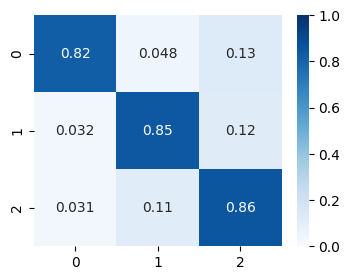

In [321]:
evaluator.plot_confusion_matrix(confusion_matrix, ['0', '1', '2'], cmap='Blues')

In [322]:
manager = WeightManager(artifacts_path.joinpath("gcn.pth").as_posix())
model_path = manager.get_filename()

In [323]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\gcn\gcn.pth, model size is 0.25MiB


In [324]:
manager.load_weight(model_path, model)